In [1]:
from pathlib import Path
import sys

from openeo_gfmap.features.feature_extractor import (
    EPSG_HARMONIZED_NAME,
)
from openeo_gfmap.inference.model_inference import apply_model_inference_local

# from scaleagdata_vito.openeo.feature_extractor import PrestoFeatureExtractor
# from scaleagdata_vito.openeo.inference import (
#     ScaleAgBinaryClassifier,
#     ScaleAgMulticlassClassifier,
#     ScaleAgRegressor,
# )
# from scaleagdata_vito.openeo.parameters import (
#     ScaleAgParametersBinary,
#     ScaleAgParametersMultiClass,
#     ScaleAgParametersRegression,
# )
import xarray as xr

### test

In [105]:
%load_ext autoreload
%autoreload 2
from scaleagdata_vito.presto.datasets_prometheo import ScaleAgInferenceDataset

path_to_file = Path('/home/giorgia/Private/git/worldcereal-classification/tests/worldcerealtests/testresources/worldcereal_preprocessed_inputs.nc')
cl = ScaleAgInferenceDataset(compositing_window="month")
s1, s2, meteo, dem, latlon, timestamps = cl.nc_to_array(path_to_file)
s1.shape, s2.shape, meteo.shape, dem.shape, latlon.shape, timestamps.shape


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


((10000, 1, 1, 12, 2),
 (10000, 1, 1, 12, 13),
 (10000, 12, 2),
 (10000, 1, 1, 2),
 (10000, 2),
 (10000, 12, 3))

In [ ]:
%load_ext autoreload
%autoreload 2
from prometheo.models.presto.wrapper import PretrainedPrestoWrapper, load_pretrained
from prometheo.predictors import collate_fn, Predictors
from scaleagdata_vito.presto.datasets_prometheo import InferenceDataset
from typing import Literal
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch import nn
import numpy as np

class PrestoPredictor:
    def __init__(self,
                model: PretrainedPrestoWrapper, 
                batch_size: int = 8192,
                task_type: Literal["regression", "binary", "multiclass"] = "regression",
                compositing_window: Literal["dekad", "month"] = "dekad"):
        """
        Initialize the PrestoFeatureExtractor with a Presto model.

        Args:
            model (Presto): The Presto model used for feature extraction.
            batch_size (int): Batch size for dataloader.
        """
        self.model = model
        self.batch_size = batch_size
        self.task_type = task_type
        self.compositing_window = compositing_window

    def predict(self, path_to_file: Path) -> xr.DataArray:
        cl = ScaleAgInferenceDataset(compositing_window="month")
        s1_cube, s2_cube, meteo_cube, dem_cube, latlon_cube, timestamps_cube = cl.nc_to_array(path_to_file)
        ds = InferenceDataset(s1_cube, 
                              s2_cube,
                              meteo_cube,
                              dem_cube,
                              latlon_cube, 
                              timestamps_cube)
        dl = DataLoader(
            ds, 
            batch_size=self.batch_size, 
            shuffle=False, 
            collate_fn=collate_fn
        )

        all_preds, all_probs = [], []
        self.model.eval()
        for batch in dl:
            with torch.no_grad():
                output = self.model(batch, inference=True)
                # binary classification
                if self.task_type == "binary":
                    probs = nn.functional.sigmoid(output)
                    preds = probs > 0.5
                # multiclass classification
                elif self.task_type == "multiclass":
                    probs = nn.functional.softmax(output, dim=-1)
                    preds = probs.argmax(dim=-1)
                
                all_preds.append(preds.cpu().numpy().flatten())
                all_probs.append(probs.cpu().numpy().flatten())
        
        # need to be reshaped 
        all_preds = np.concatenate(all_preds)
        all_probs = np.concatenate(all_probs)
        return all_preds, all_probs

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [122]:
# presto_url="https://artifactory.vgt.vito.be/artifactory/auxdata-public/worldcereal/models/PhaseII/presto-ss-wc_longparquet_random-window-cut_no-time-token_epoch96.pt"
# presto_url="https://artifactory.vgt.vito.be/artifactory/auxdata-public/worldcereal/models/PhaseII/presto-ss-wc-ft-ct_cropland_CROPLAND2_30D_random_time-token%3Dnone_balance%3DTrue_augment%3DTrue.pt"
presto_url = "/home/giorgia/Private/git/scaleag-vito/presto-prometheo-binary-CROPLAND2-timeexplicit=False-run=202504161049.pt"
task_type = "binary" # "regression", "binary", "multiclass"
num_outputs = 14
if task_type == "regression":
    finetuned_model = PretrainedPrestoWrapper(num_outputs=1, regression=True)
elif task_type == "binary":
    finetuned_model = PretrainedPrestoWrapper(num_outputs=1, regression=False)
elif task_type == "multiclass":
    finetuned_model = PretrainedPrestoWrapper(num_outputs=num_outputs, regression=False)

finetuned_model = load_pretrained( finetuned_model, presto_url)
presto_model = PrestoPredictor(
    model=finetuned_model,
    batch_size=50,
    task_type=task_type,
    compositing_window="month",
)

preds, probs = presto_model.predict(path_to_file)

In [123]:
from einops import rearrange
path_to_file_target = Path('/home/giorgia/Private/git/worldcereal-classification/tests/worldcerealtests/testresources/worldcereal_cropland_classification.nc')
target_arr = xr.open_dataarray(path_to_file_target).astype('uint16')
target_pred = target_arr.sel(bands='classification').data
target_probs = target_arr.sel(bands='probability_cropland').data
input_arr = xr.load_dataset(path_to_file)
x_coords = input_arr.x.values
y_coords = input_arr.y.values
preds_map = rearrange(preds, '(y x) -> y x', y=len(y_coords), x=len(x_coords))
prob_map = rearrange(probs, '(y x) -> y x', y=len(y_coords), x=len(x_coords))
bands = ['S2-L2A-B04', 'S2-L2A-B03', 'S2-L2A-B02']
rgb = np.stack([input_arr[band].values for band in bands], axis=-1)

In [125]:
prob_map.min(), prob_map.max()

(0.9414037, 0.94253397)

In [102]:
def min_max_normalize(image):
    # Ensure the input is a numpy array
    image = np.array(image, dtype=np.float32)
    
    # Compute the minimum and maximum values for the entire image
    min_val = image.min()
    max_val = image.max()
    
    # Perform min-max normalization
    normalized_image = (image - min_val) / (max_val - min_val)
    
    return normalized_image

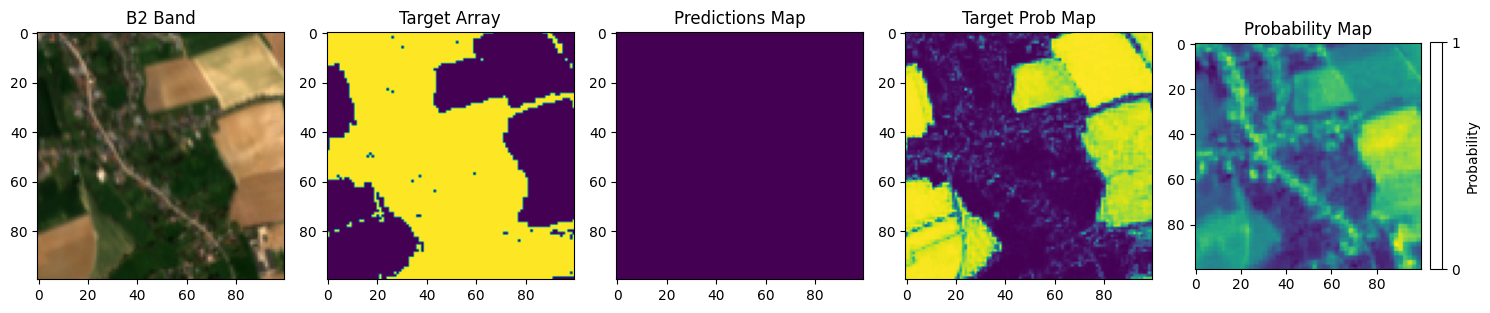

In [124]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 5, figsize=(15, 5))
i = 5
# Plot the B2 band
axs[0].imshow(min_max_normalize(rgb[i]))
axs[0].set_title('B2 Band')

# Plot the target_arr
axs[1].imshow(target_pred, cmap='viridis')
axs[1].set_title('Target Array')

# Plot the preds_map
axs[2].imshow(preds_map, cmap='viridis')
axs[2].set_title('Predictions Map')

# Plot the preds_map
axs[3].imshow(target_probs, cmap='viridis')
axs[3].set_title('Target Prob Map')

# Plot the prob_map
axs[4].imshow(prob_map, cmap='viridis')
axs[4].set_title('Probability Map')
cbar = fig.colorbar(axs[4].images[0], ax=axs[4], fraction=0.046, pad=0.04)
cbar.set_ticks([0, 1])
cbar.set_label('Probability')
plt.tight_layout()
